In [3]:
import numpy as np
import torch

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import os

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50'

In [6]:
manifolds = np.load(os.path.join(emb_path,'manifolds.npy'),allow_pickle=True)

In [467]:
Rs = np.load(os.path.join(emb_path,'Rs.npy'))

In [430]:
from scipy.spatial.distance import cdist

In [708]:
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier(n_neighbors=1)

In [721]:
Xa = manifolds[0][:500]
Xb = manifolds[1][:500]

navg = 100
errs = []
err_proto = []
ms = np.arange(1,100,5)
for m in tqdm(ms):
    Xak = Ua[:,:k]*Sa[:k]@Va[:k]
    for _ in range(navg):
        idxs_a = np.random.permutation(K)
        idxs_b = np.random.permutation(K)

        xatrain,xatest = np.split(Xa[idxs_a],(m,))
        xbtrain,xbtest = np.split(Xb[idxs_b],(m,))

        xtrain = np.vstack([xatrain,xbtrain])
        y = np.concatenate([np.ones(m),-np.ones(m)])

        nn.fit(xtrain,y)
        yahat = nn.predict(xatest)
        ybhat = nn.predict(xbtest)

        err = ((yahat!=1).mean() + (ybhat!=-1).mean())/2
        errs.append(err)
        
        w = (xatrain-xbtrain).mean(0)
        mu = (xatrain+xbtrain).mean(0)/2
        ha = xatest@w - w@mu
        hb = xbtest@w - w@mu
        err_a = (ha<0).mean()
        err_b = (hb>0).mean()
        err_proto.append((err_a+err_b)/2)
errs = np.stack(errs).reshape(len(ms),navg).mean(-1)
err_proto = np.stack(err_proto).reshape(len(ms),navg).mean(-1)

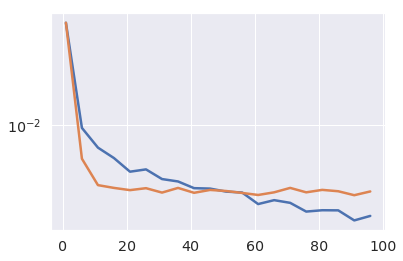

In [722]:
plt.plot(ms, errs)
plt.plot(ms, err_proto)
plt.yscale('log')

In [544]:
Xa = manifolds[0][:500]
Xb = manifolds[1][:500]

x0a = Xa.mean(0)
Ua,Sa,Va = np.linalg.svd(Xa - x0a)

x0b = Xb.mean(0)
Ub,Sb,Vb = np.linalg.svd(Xb - x0b)

In [553]:
a = 10
b = 12
Xa = manifolds[a][:500]
Xb = manifolds[b][:500]

x0a = Xa.mean(0)
Ua,Sa,Va = np.linalg.svd(Xa - x0a)

x0b = Xb.mean(0)
Ub,Sb,Vb = np.linalg.svd(Xb - x0b)

In [472]:
K = len(Xa)
ks = np.logspace(1,8,20,base=2,dtype='int')

dds = []
for k in tqdm(ks):
    Xak = Ua[:,:k]*Sa[:k]@Va[:k]
    Xak *= (Rs[a]**2).sum() / (Rs[a,:k]**2).sum()
    Xak += x0a
    Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
    Xbk *= (Rs[b]**2).sum() / (Rs[b,:k]**2).sum()
    Xbk += x0b

    daa = cdist(Xak,Xak) + np.eye(K)*1e6
    dab = cdist(Xak,Xbk) + np.eye(K)*1e6
    
    dd = (np.min(dab,axis=-1) - np.min(daa,axis=-1)) / np.min(daa,axis=-1)
    dds.append(np.mean(dd))

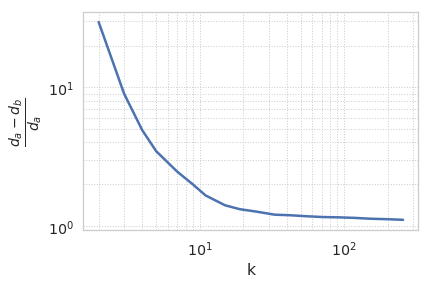

In [473]:
with sns.axes_style('whitegrid'):
    plt.plot(ks,dds)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both",ls = ':')
    plt.xlabel('k')
    plt.ylabel(r'$\frac{d_a-d_b}{d_a}$',fontsize=20)

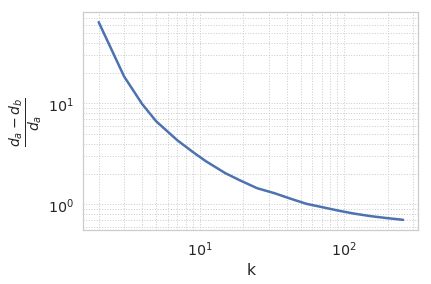

In [389]:
with sns.axes_style('whitegrid'):
    plt.plot(ks,dds)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both",ls = ':')
    plt.xlabel('k')
    plt.ylabel(r'$\frac{d_a-d_b}{d_a}$',fontsize=20)

In [395]:
K = len(Xa)
ks = np.logspace(1,8,20,base=2,dtype='int')

ms = [1,2,5,10]
dds = []
for m in tqdm(ms):
    for k in ks:
        Xak = Ua[:,:k]*Sa[:k]@Va[:k] + x0a
        Xbk = Ub[:,:k]*Sb[:k]@Vb[:k] + x0b

        Xam = Xak[:K//2].reshape(m,-1,2048).mean(0)
        daa = cdist(Xak[K//2:],Xam)

        Xbm = Xbk[:K//2].reshape(m,-1,2048).mean(0)
        dab = cdist(Xak[K//2:],Xbm)

        dd =  (np.min(dab,axis=0) - np.min(daa,axis=0)) / np.min(daa,axis=0)
        dds.append(np.min(dd))
dds = np.stack(dds).reshape(len(ms),len(ks))

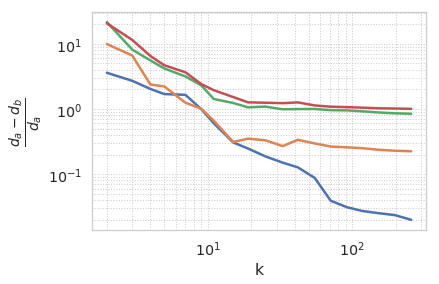

In [396]:
with sns.axes_style('whitegrid'):
    plt.plot(ks,dds.T)

    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both",ls = ':')
    plt.xlabel('k')
    plt.ylabel(r'$\frac{d_a-d_b}{d_a}$',fontsize=20)

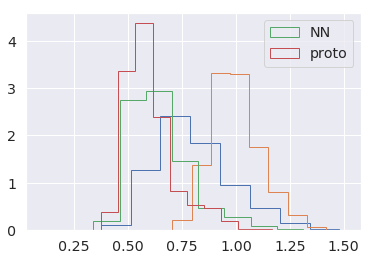

In [765]:
k = 500
m = 10
Xak = Ua[:,:k]*Sa[:k]@Va[:k]
Xak *= (Rs[a]**2).sum() / (Rs[a,:k]**2).sum()
Xak += x0a
Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
Xbk *= (Rs[b]**2).sum() / (Rs[b,:k]**2).sum()
Xbk += x0b

daa = cdist(Xak[K//2:],Xak[:K//2])
dab = cdist(Xak,Xbm)

# NN
daNN = daa.reshape(m,-1).min(0)

plt.hist(daa.ravel()/dab.mean(),histtype='step', density=True)
plt.hist(dab.ravel()/dab.mean(),histtype='step', density=True)
plt.hist(daNN.ravel()/dab.mean(),histtype='step', density=True, label='NN')

Xam = Xak[:K//2].reshape(m,-1,2048).mean(0)
daproto = cdist(Xak[K//2:],Xam)
plt.hist(daproto.ravel()/dab.mean(),histtype='step', density=True, label='proto');
plt.legend();

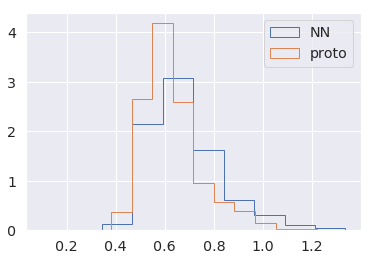

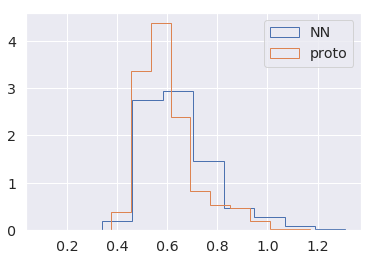

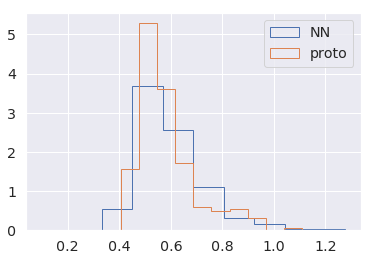

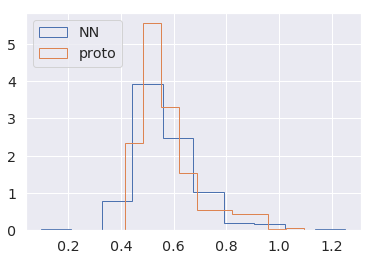

In [762]:
k = 500
ms = [5,10,50,125]
for m in ms:
    plt.figure()
    Xak = Ua[:,:k]*Sa[:k]@Va[:k]
    Xak *= (Rs[a]**2).sum() / (Rs[a,:k]**2).sum()
    Xak += x0a
    Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
    Xbk *= (Rs[b]**2).sum() / (Rs[b,:k]**2).sum()
    Xbk += x0b

    daa = cdist(Xak[K//2:],Xak[:K//2])
    dab = cdist(Xak,Xbm)

    # NN
    daNN = daa.reshape(m,-1).min(0)

    # plt.hist(daa.ravel()/dab.mean(),histtype='step', density=True)
    # plt.hist(dab.ravel()/dab.mean(),histtype='step', density=True)
    plt.hist(daNN.ravel()/dab.mean(),histtype='step', density=True, label='NN')

    Xam = Xak[:K//2].reshape(m,-1,2048).mean(0)
    daproto = cdist(Xak[K//2:],Xam)
    plt.hist(daproto.ravel()/dab.mean(),histtype='step', density=True, label='proto');
    plt.legend();

(array([2.31232336e-04, 4.62464671e-04, 1.08563582e-01, 1.26969675e+00,
        2.40678177e+00, 1.83482858e+00, 9.64470072e-01, 4.75066834e-01,
        1.46254452e-01, 1.96547485e-02]),
 array([0.09618   , 0.23456895, 0.3729579 , 0.51134685, 0.6497358 ,
        0.78812475, 0.9265137 , 1.06490264, 1.20329159, 1.34168054,
        1.48006949]),
 <a list of 1 Patch objects>)

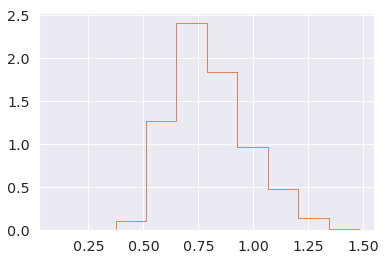

In [741]:
plt.hist(daa.ravel()/dab.mean(),histtype='step', density=True)
plt.hist(daNN.ravel()/dab.mean(),histtype='step', density=True)

(array([7.03204976e-05, 3.51602488e-05, 7.38365225e-03, 1.16696866e-01,
        1.67890188e-01, 8.86741475e-02, 3.31912749e-02, 1.70878809e-02,
        6.15304354e-03, 2.32057642e-03]),
 array([ 1.76630878,  4.04160553,  6.31690229,  8.59219904, 10.86749579,
        13.14279255, 15.4180893 , 17.69338606, 19.96868281, 22.24397956,
        24.51927632]),
 <a list of 10 Patch objects>)

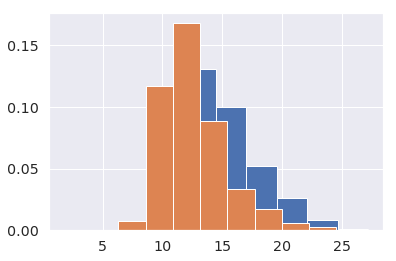

In [735]:
plt.hist(daa.ravel(),density=True)
plt.hist(daNN.ravel(),density=True)

(0, 2.0)

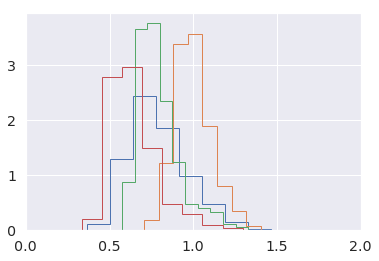

In [556]:
k = 500
m = 1
Xak = Ua[:,:k]*Sa[:k]@Va[:k]
Xak *= (Rs[a]**2).sum() / (Rs[a,:k]**2).sum()
Xak += x0a
Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
Xbk *= (Rs[b]**2).sum() / (Rs[b,:k]**2).sum()
Xbk += x0b

Xam = Xak[:K//2].reshape(m,-1,2048).mean(0)
daa = cdist(Xak[K//2:],Xam)

Xbm = Xbk[:K//2].reshape(m,-1,2048).mean(0)
dab = cdist(Xak[K//2:],Xbm)

plt.hist(daa.ravel()/dab.mean(),histtype='step', density=True)
plt.hist(dab.ravel()/dab.mean(),histtype='step', density=True)

m = 10
daamean = daa.reshape(m,-1).mean(0) /dab.mean()
plt.hist(daamean,histtype='step', density=True)

daamean = daa.reshape(m,-1).min(0) /dab.mean()
plt.hist(daamean,histtype='step',density=True)
plt.xlim([0,2.])


(0, 2.0)

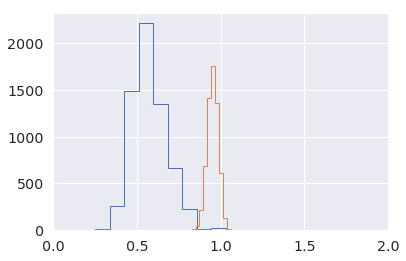

In [529]:
m = 10
daamean = daa.reshape(m,-1).min(0) /dab.mean()
dabmean = dab.reshape(m,-1).min(0) /dab.mean()

plt.hist(daamean,histtype='step')
plt.hist(dabmean,histtype='step')
plt.xlim([0,2.])

In [544]:
Xa = manifolds[0][:500]
Xb = manifolds[1][:500]

x0a = Xa.mean(0)
Ua,Sa,Va = np.linalg.svd(Xa - x0a)

x0b = Xb.mean(0)
Ub,Sb,Vb = np.linalg.svd(Xb - x0b)

In [545]:
navg = 100
errs = []
err_proto = []
for k in tqdm(ks):
    Xak = Ua[:,:k]*Sa[:k]@Va[:k]
    Xak *= (Rs[a]**2).sum() / (Rs[a,:k]**2).sum()
    Xak += x0a
    Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
    Xbk *= (Rs[b]**2).sum() / (Rs[b,:k]**2).sum()
    Xbk += x0b

    for _ in range(navg):
        idxs_a = np.random.permutation(K)
        idxs_b = np.random.permutation(K)

        xatrain,xatest = np.split(Xak[idxs_a],(m,))
        xbtrain,xbtest = np.split(Xbk[idxs_b],(m,))

        xtrain = np.vstack([xatrain,xbtrain])
        y = np.concatenate([np.ones(m),-np.ones(m)])

        nn.fit(xtrain,y)
        yahat = nn.predict(xatest)
        ybhat = nn.predict(xbtest)

        err = ((yahat!=1).mean() + (ybhat!=-1).mean())/2
        errs.append(err)
        
        w = (xatrain-xbtrain).mean(0)
        mu = (xatrain+xbtrain).mean(0)/2
        h = xatest@w - w@mu
        err = (h<0).mean()
        err_proto.append(err)
errs = np.stack(errs).reshape(len(ks),navg).mean(-1)
err_proto = np.stack(err_proto).reshape(len(ks),navg).mean(-1)

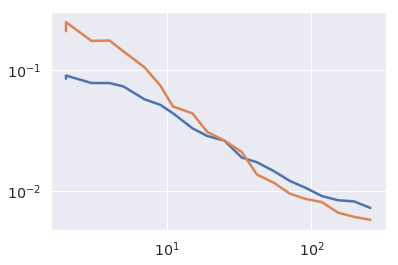

In [546]:
plt.plot(ks, errs)
plt.plot(ks, err_proto)
plt.xscale('log')
plt.yscale('log')

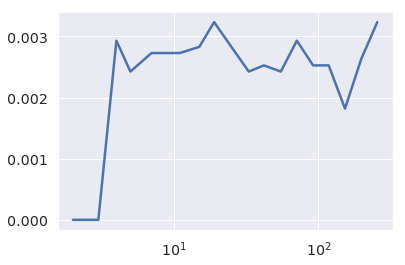

In [462]:
plt.plot(ks, errs)
plt.xscale('log')

In [507]:
N = 5000
X = np.random.randn(m,N)
Y = np.random.randn(N)
X0 = X.mean(0)

In [515]:
((X-Y)**2).sum(-1)

array([10301.28012082,  9973.16104665, 10218.03955633,  9994.68989619,
       10211.39306289, 10293.83136541, 10253.97427266, 10339.23245439,
       10077.44627971, 10102.74922224])

In [516]:
np.sqrt(((X-Y)**2).sum(-1)).mean()

100.87715037368135

In [511]:
np.sqrt(((X0-Y)**2).sum(-1))

75.40627940827969

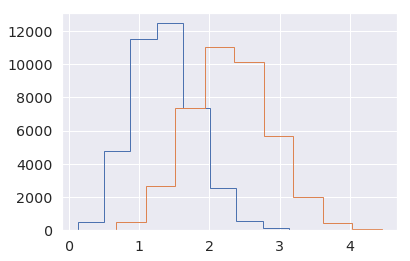

In [558]:
N = 5
U = np.random.randn(N,N)
U,_ = np.linalg.qr(U)

x0 = U[0] 

sa = np.random.randn(P,N) / np.sqrt(N)
sb = np.random.randn(P,N) / np.sqrt(N)
sigma = np.random.randn(P,N) / np.sqrt(N)

xa = x0 + sa
xia = x0 + sigma
xb = -x0 + sb

daa = cdist(xa,xia)
dab = cdist(xa,xb)

mask = np.eye(P,dtype='bool')
plt.hist(cdist(xa,xia)[~mask],histtype='step')
plt.hist(cdist(xa,xb)[~mask],histtype='step');

In [569]:
U = np.random.randn(m+1,N)
U,_ = np.linalg.qr(U.T)

In [570]:
U.shape

(2000, 11)

In [593]:
N = 2000
U = np.random.randn(m+1,N)
U,_ = np.linalg.qr(U.T)
U = U.T
# X = np.random.randn(m,N)
# Y = np.random.randn(N)
X = U[:-1]
Y = U[-1]
print(((Y - X.mean(0))**2).sum())
print(((Y - X)**2).sum(-1).mean()*(m-1)/m)

1.1
1.8


In [702]:
P = 2000
N = 500
m = 10
s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
mu = np.random.randn(N) / np.sqrt(N)
X = mu + s

s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
X2 = mu + s

s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
Y = -mu + s

daa = cdist(X,X2)
dab = cdist(X,Y)

s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
X = mu + s
X = X.reshape(m,-1,N).mean(0)
daproto = cdist(X,X2)

s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
X = mu + s
damin = cdist(X,X2).reshape(m,-1,P).min(0)

(array([2.76541184e-04, 2.18372176e-03, 1.14621553e-02, 5.50603033e-02,
        2.02113462e-01, 6.27834310e-01, 1.56240047e+00, 3.13012198e+00,
        5.06966741e+00, 6.63795153e+00, 7.04005195e+00, 6.01899515e+00,
        4.12378213e+00, 2.24996768e+00, 9.65643670e-01, 3.36150113e-01,
        8.86934327e-02, 1.82612540e-02, 2.79401955e-03, 2.00253961e-04]),
 array([2.2291888 , 2.25540551, 2.28162222, 2.30783893, 2.33405564,
        2.36027235, 2.38648906, 2.41270577, 2.43892248, 2.46513919,
        2.4913559 , 2.51757261, 2.54378932, 2.57000603, 2.59622274,
        2.62243945, 2.64865616, 2.67487287, 2.70108958, 2.72730629,
        2.753523  ]),
 <a list of 1 Patch objects>)

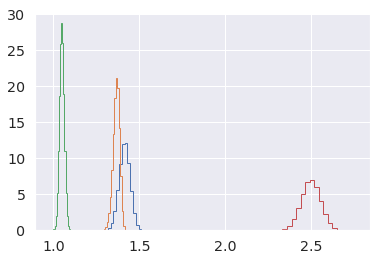

In [703]:
mask = np.eye(P,dtype='bool')
plt.hist(daa.ravel(), bins=20, histtype='step', density=True)
plt.hist(damin.ravel(), bins=20, histtype='step', density=True)
plt.hist(daproto.ravel(), bins=20, histtype='step', density=True)
plt.hist(dab.ravel(), bins=20, histtype='step', density=True)
# plt.axvline(np.sqrt(2))
# plt.axvline(np.sqrt(2)+1);

(array([2.36123696e-04, 2.82174340e-03, 1.22810413e-02, 3.35660923e-02,
        7.21194823e-02, 1.32211006e-01, 2.17463401e-01, 3.21833989e-01,
        4.36768828e-01, 5.43829400e-01, 6.14712168e-01, 6.32418836e-01,
        6.01275294e-01, 5.34580134e-01, 4.28268375e-01, 3.09695143e-01,
        1.94470693e-01, 9.61375672e-02, 2.97724585e-02, 3.74145172e-03]),
 array([0.64598835, 0.8376252 , 1.02926204, 1.22089889, 1.41253573,
        1.60417258, 1.79580942, 1.98744627, 2.17908311, 2.37071995,
        2.5623568 , 2.75399364, 2.94563049, 3.13726733, 3.32890418,
        3.52054102, 3.71217786, 3.90381471, 4.09545155, 4.2870884 ,
        4.47872524]),
 <a list of 1 Patch objects>)

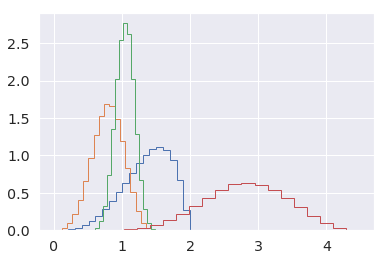

In [701]:
mask = np.eye(P,dtype='bool')
plt.hist(daa.ravel(), bins=20, histtype='step', density=True)
plt.hist(damin.ravel(), bins=20, histtype='step', density=True)
plt.hist(daproto.ravel(), bins=20, histtype='step', density=True)
plt.hist(dab.ravel(), bins=20, histtype='step', density=True)
# plt.axvline(np.sqrt(2))
# plt.axvline(np.sqrt(2)+1);

# Spheres

In [5]:
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier(n_neighbors=1)

In [12]:
import numpy as np

In [40]:
P = 100
N = 500
m = 10
dx0 = 1

def sphere_experiment(m,N):
    s = np.random.randn(m,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    mu = np.random.randn(N) / np.sqrt(N)
    Xatrain = mu*dx0/2 + s

    s = np.random.randn(P,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xatest = mu*dx0/2 + s

    s = np.random.randn(m,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xbtrain = -mu*dx0/2 + s

    w = Xatrain.mean(0) - Xbtrain.mean(0)
    mu = (Xatrain.mean(0) + Xbtrain.mean(0))/2
    h = Xatest@w - w@mu
    proto_err = (h<0).mean()

    ytrain = np.concatenate([np.ones(m),-np.ones(m)])
    Xtrain = np.vstack([Xatrain,Xbtrain])
    nn.fit(Xtrain,ytrain)
    yhat = nn.predict(Xatest)
    NN_err = (yhat!=1).mean()
    
    return proto_err, NN_err

In [76]:
proto_errs = []
NN_errs = []

Ns = np.arange(1,11)
ms = np.linspace(2,1000,100,dtype='int')
n_avg = 100
for m in tqdm(ms):
    for N in Ns:
        for _ in range(n_avg):
            proto_err, NN_err = sphere_experiment(m,N)
            proto_errs.append(proto_err)
            NN_errs.append(NN_err)
proto_errs = np.stack(proto_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)
NN_errs = np.stack(NN_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)

In [79]:
proto_err_stash = proto_errs
NN_errs_stash = NN_errs

(1, 10)

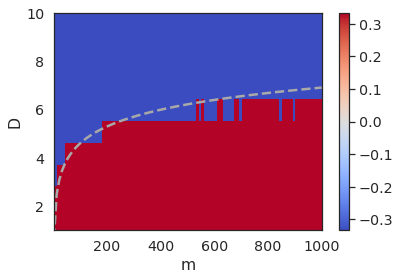

In [78]:
with sns.axes_style('white'):
    diff = np.sign(proto_errs - NN_errs).T
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
              cmap='coolwarm',aspect='auto',vmin=-vmax/3,vmax=vmax/3)
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='darkgrey',linestyle='dashed')
    plt.colorbar()
plt.xlabel('m')
plt.ylabel('D');
plt.ylim(np.min(Ns),np.max(Ns))